Импортируем необходимые библиотеки

In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt

Импорт данных

In [2]:
# с помощью системной библиотеки OS определяем путь до файла с данными ЭКГ
dirname = os.path.abspath(os.curdir)

# загружаем данные в переменную, содержащую объект библиотеки Pandas - Dataframe
rawdata = pd.read_csv(path.join(os.sep, dirname, 'Total daily precipitation Fisher River near Dallas Jan 01 1988 to Dec .csv'))

# устанавливаем индекс времени для временного ряда и сортируем по нему выборку
data = rawdata.set_index('Unnamed: 0').sort_index()

data = data.rename(columns={'x': 'Count'})
rawdata = rawdata.rename(columns={'x': 'Count'})

In [3]:
data.head()

,Count
Unnamed: 0,
1,0.0
2,3.0
3,1.0
4,0.0
5,0.0


In [4]:
data.describe()

,Count
count,1461.000000
mean,1.617796
std,4.520368
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,47.000000


## Предсказание временного ряда с помощью деревьев

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray
from sklearn.ensemble import IsolationForest
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [6]:
n_vars = 1 if type(data) is list else data.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(data.shift(i))
for i in range(0, 1):
    cols.append(data.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [7]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [8]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [9]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  2.6207733778709557


In [12]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 4.560529773462264
MAPE: 5426662299077008.0
MAE: 2.6207733778709557
R2:  -0.03782354092323903


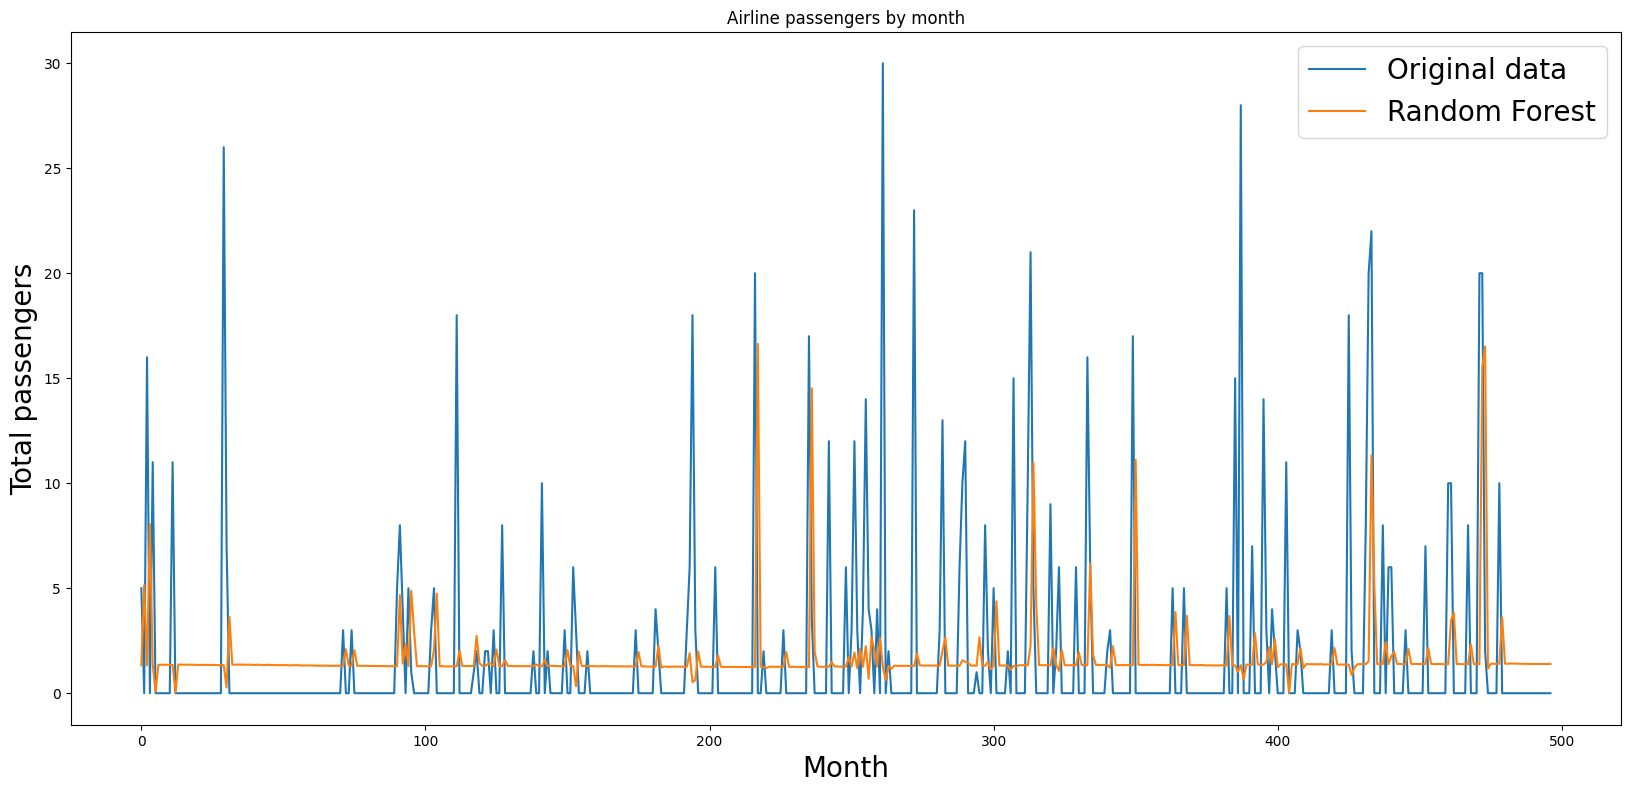

In [13]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

In [14]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [15]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 4.648205943448154
MAPE: 5483084318239503.0
MAE: 2.63797635369076
R2:  -0.07811142938510995


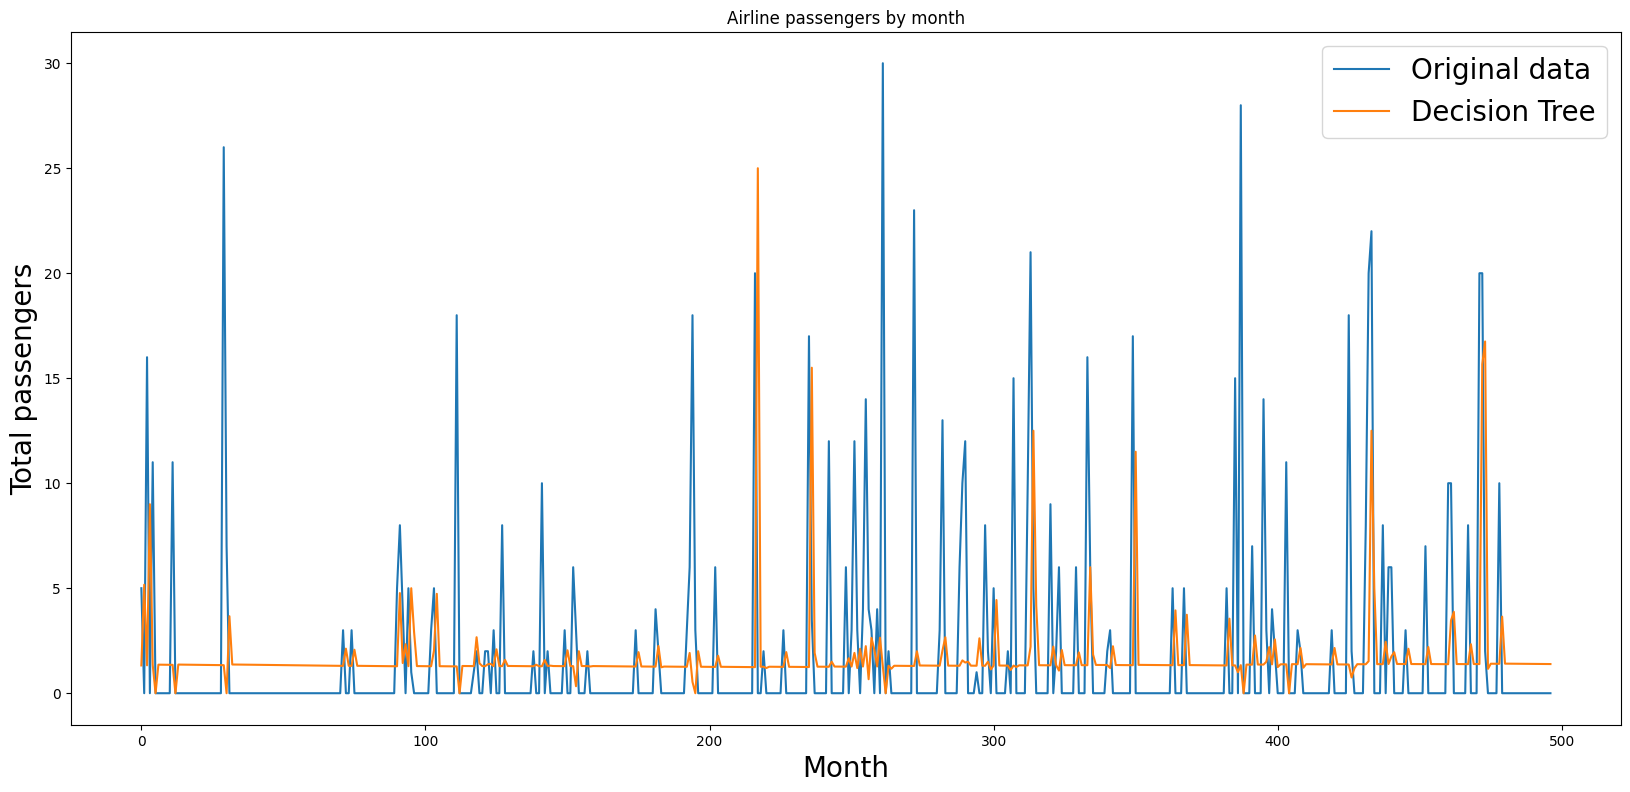

In [16]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [4]:
model = IsolationForest(contamination=0.004)
model.fit(data[['Count']])

IsolationForest(contamination=0.004)

In [5]:
data_with_out = data.copy()
data_with_out['outliers'] = pd.Series(model.predict(data_with_out[['Count']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [6]:
data_with_out.query('outliers=="yes"')

,Count,outliers
Unnamed: 0,,
187,0.0,yes
527,0.0,yes
528,47.0,yes
614,0.0,yes
1225,0.0,yes


In [7]:
fig = px.scatter(data_with_out.reset_index(), x='Unnamed: 0', y='Count', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()